# Retention Rate

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from pylab import plot, show, text
import datetime
import matplotlib.dates as mdates
import pylab

%matplotlib inline

In [2]:
logins_df = pd.read_json('data/logins.json')

logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df.index = pd.to_datetime(logins_df.login_time, unit='m')
logins_df.head()

,login_time
login_time,
1970-01-01 20:13:18,1970-01-01 20:13:18
1970-01-01 20:16:10,1970-01-01 20:16:10
1970-01-01 20:16:37,1970-01-01 20:16:37
1970-01-01 20:16:36,1970-01-01 20:16:36
1970-01-01 20:26:21,1970-01-01 20:26:21


## Part 1 : Exploratory Data Analysis

Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,such as daily cycles. If there are data quality issues, please report them.



In [4]:
# resampling df to 15-minute intervals
df_freq = logins_df.groupby(pd.Grouper(freq='15Min')).agg(['count']).rename(columns=dict(count='counts'))
df_freq.columns = df_freq.columns.droplevel(0)
df_freq = df_freq.reset_index(drop=False)

df_freq.tail()

,login_time,counts
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7
9787,1970-04-13 18:45:00,6


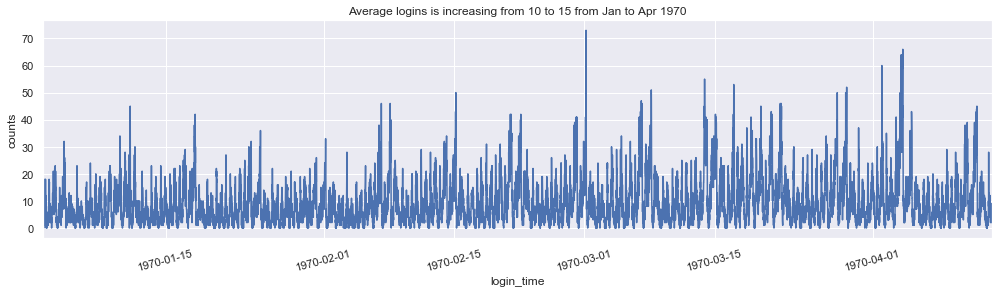

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(17, 4)
sns.lineplot(x='login_time', y='counts', data= df_freq, ax=ax)
ax.set_xlim(df_freq['login_time'].min(), df_freq['login_time'].max())
plt.title('Average logins is increasing from 10 to 15 from Jan to Apr 1970')
plt.xticks(rotation=15)
plt.show()


From the the visualization above, we could observe a pattern or cycle in the time series.

In [6]:
# extracting hours and days
df_freq['hour'] = df_freq['login_time'].dt.hour
df_freq['day'] = df_freq['login_time'].dt.day_name()

# giving AM/PM labels
day_or_night = lambda row: "AM" if row in range(0,12) else "PM"
df_freq["AM-PM"] = df_freq["hour"].apply(day_or_night)

# show
display(df_freq.head())

,login_time,counts,hour,day,AM-PM
0,1970-01-01 20:00:00,2,20,Thursday,PM
1,1970-01-01 20:15:00,6,20,Thursday,PM
2,1970-01-01 20:30:00,9,20,Thursday,PM
3,1970-01-01 20:45:00,7,20,Thursday,PM
4,1970-01-01 21:00:00,1,21,Thursday,PM


In [7]:
# getting total logins per day of week
df_day = df_freq.groupby("day").sum()[['counts']]

# getting average daily logins per day of week
df_day["daily_avg"] = df_freq.groupby("day").mean()[["counts"]]

# show
display(df_day)

,counts,daily_avg
day,,
Friday,15208,10.561111
Monday,8823,6.213380
Saturday,19377,13.456250
Sunday,18167,12.615972
Thursday,11960,8.794118
Tuesday,9268,6.895833
Wednesday,10339,7.692708


The weekends showed to have the most user logins.

In [8]:
#getting total logins per hour
df_hour = df_freq.groupby("hour").sum()[["counts"]]

#getting average hourly logins per hour of day
df_hour["hourly_avg"] = df_freq.groupby("hour").mean()[["counts"]]

#show
display(df_hour)

,counts,hourly_avg
hour,,
0,5993,14.688725
1,6317,15.482843
2,5800,14.215686
3,4831,11.840686
4,5034,12.338235
5,2945,7.218137
6,1138,2.789216
7,815,1.997549
8,818,2.004902


In [9]:
#aggregating by sum
df_total = df_freq.groupby(["day", "AM-PM"]).sum()[["counts"]]

#aggregating by mean
df_total["total_avg"] = df_freq.groupby(["day", "AM-PM"]).mean()[["counts"]]

#show
display(df_total)

counts  total_avg
day       AM-PM                   
Friday    AM       5924   8.227778
          PM       9284  12.894444
Monday    AM       3905   5.423611
          PM       4918   7.025714
Saturday  AM      10217  14.190278
          PM       9160  12.722222
Sunday    AM      10351  14.376389
          PM       7816  10.855556
Thursday  AM       5153   7.668155
          PM       6807   9.893895
Tuesday   AM       3961   5.894345
          PM       5307   7.897321
Wednesday AM       4570   6.800595
          PM       5769   8.584821

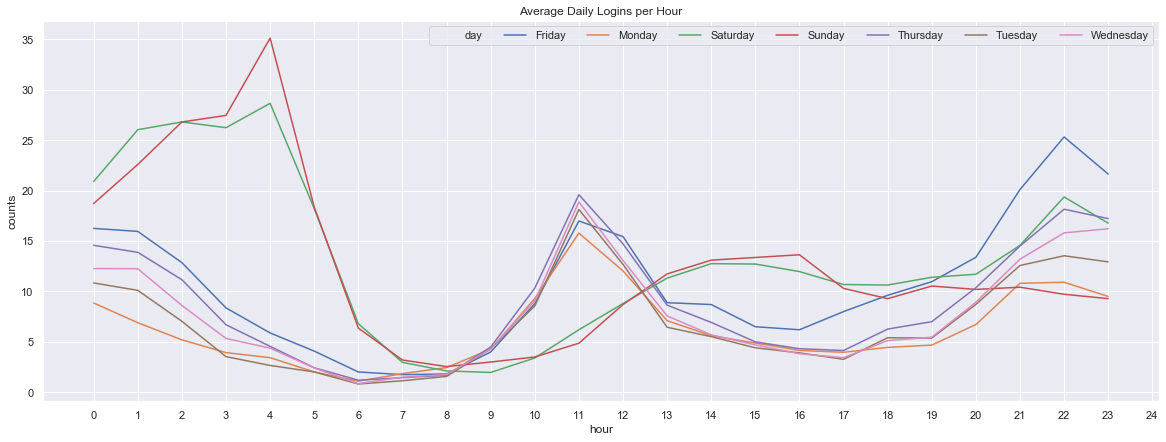

In [10]:
#getting average daily logins per hour
df_total = df_freq.groupby(["hour", "day"]).mean().reset_index()

#plotting df
f, axes = plt.subplots(figsize=(20,7))
ax = sns.lineplot(x="hour", y="counts", data=df_total, hue="day")
ax.legend(loc="upper right", ncol=8)
ax.set(title="Average Daily Logins per Hour")
plt.xticks(range(0,25))

#display plot
plt.show()

### Observation

1. Login peak hours is from 21:00 to 5:00
2. Max peak hours is from 3:00 to 5:00 AM with 50 to 73 logins

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

* Answer : For a single KPI, a measure of the ratio of activity of a driver in the other city. For example, assume driver A from Gotham drove 100 times. Only 5 of them were in Metropolis. Driver A's ratio is then 5%. Currently, drivers in both cities have high ratios towards their primary city. Ultimate would like to move these ratios towards 50% so that the drivers are closer to evenly distributed: driving in both cities. This metric would show the experiment working or not working reasonably well.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a. how you will implement the experiment

* Answer : Measure the gross income of taxi and logistics transportation companies for both cities before and after implementing reimbursement of toll costs


b. what statistical test(s) you will conduct to verify the significance of the observation

* Answer : To test the effectiveness of free toll fee, use t-test for paired observations. It is paired observation because the same taxi/transportation company will be compared before and after implementing toll free*

c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

* Answer : The null hypothesis is the gross income of taxi and transportation companies for Gotham city is the same for free toll and for non-free toll costs The alternative hypothes is the gross income of taxi and transportation companies for Gotham city with free toll is greater than for non-free toll costs*


Another hypotheses are as follow: The null hypothesis is the gross income of taxi and transportation companies for Metropolis city is the same for free toll and for non-free toll costs The alternative hypothes is the gross income of taxi and transportation companies for Metropolis city with free toll is greater than for non-free toll costs
Iterpret the results based on t-statistic if it is significant at 5% or 1%. If the null hypothesis is/are rejected then there is an evidence to support that free toll fee is beneficial to one or both cities. However, the limitations/assumptions are 1) within the duration of the experiment, both cities are not affected by factors due to seasonality or peak season. 2) The traffic conditions for both cities before and after the experiment are the same.

## Part 3 - Predictive Modeling

In [11]:
# import data from json file
file = 'data/ultimate_data_challenge.json'
with open(file) as f:
    data = json.loads(f.read())
df = pd.DataFrame(data)

In [12]:
df.head(10)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9
5,Winterfell,2,2014-01-09,3.5,1.00,2014-06-06,iPhone,0.0,True,100.0,10.56,5.0
6,Astapor,1,2014-01-24,NaN,1.00,2014-01-25,Android,0.0,False,100.0,3.95,4.0
7,Winterfell,2,2014-01-28,5.0,1.00,2014-01-29,iPhone,0.0,False,100.0,2.04,5.0
8,Winterfell,2,2014-01-21,4.5,1.00,2014-02-01,Android,0.0,False,100.0,4.36,5.0
9,Winterfell,1,2014-01-03,NaN,1.00,2014-01-05,Android,0.0,False,0.0,2.37,5.0


In [13]:
# inspect dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
# break down trip counts by percentage
df_tripcounts = df['trips_in_first_30_days'].value_counts(normalize=True)*100
df_tripcounts.head(7)

0    30.780
1    28.216
2    14.804
3     7.576
4     5.124
5     3.232
6     2.268
Name: trips_in_first_30_days, dtype: float64

In [15]:
# percentage of retained drivers
np.sum(df_tripcounts[1:])

69.22

In [16]:
# drop rows with missing value
df = df.drop(df[df.phone.isna()==True].index,axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    41578 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49406 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


### EDA


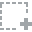
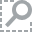
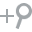
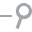
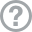
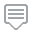
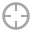
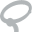
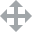
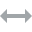
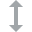
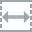
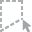
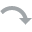
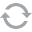
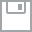
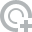
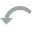
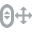
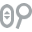
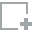
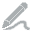
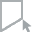
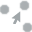
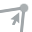

In [18]:
from dataprep.eda import plot
plot(df)

### Feature Engineering

In [19]:
#fill missing values by averaging the mean and median
fill_val = (4.777861+5) / 2
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(value=fill_val)

#fill missing values with median value
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(value=4.9)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49604 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    49604 non-null  object 
 1   trips_in_first_30_days  49604 non-null  int64  
 2   signup_date             49604 non-null  object 
 3   avg_rating_of_driver    49604 non-null  float64
 4   avg_surge               49604 non-null  float64
 5   last_trip_date          49604 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               49604 non-null  float64
 8   ultimate_black_user     49604 non-null  bool   
 9   weekday_pct             49604 non-null  float64
 10  avg_dist                49604 non-null  float64
 11  avg_rating_by_driver    49604 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.6+ MB


In [21]:
# convert to timestamp
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [22]:
# set current date 
current_date = df['last_trip_date'].max()

In [23]:
# define active user
df['active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days>30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [24]:
#create dummy variables for categorical features
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()
#set target and drop unuseful columns
target = df_features['active']
df_features = df_features.drop(['last_trip_date','signup_date','active'],axis=1)

In [26]:
df.active.value_counts(normalize=True)*100

0    62.35989
1    37.64011
Name: active, dtype: float64

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression

In [28]:
# scale data
scaler = QuantileTransformer()
scaled_features = scaler.fit_transform(df_features)

In [29]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2,random_state=42)


In [30]:
# build random forest model with 1000 estimators
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [31]:
rf.score(X_test,y_test)

0.7493196250377986

In [32]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Cross Validated Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.75264484 0.74798387 0.75352823 0.74697581 0.74294355]
Mean Cross Validated Score: 0.7491175245795076


In [33]:
df_importance = pd.DataFrame(zip(list(df_features.columns),rf.feature_importances_),index=range(df_features.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
5,avg_dist,0.300746
4,weekday_pct,0.133930
6,avg_rating_by_driver,0.111243
1,avg_rating_of_driver,0.080742
0,trips_in_first_30_days,0.080585
3,surge_pct,0.078285
2,avg_surge,0.068612
8,city_King's Landing,0.046843
11,phone_iPhone,0.019921
10,phone_Android,0.019167


In [34]:
# more metrics for our model
precision_recall_fscore_support(y_test,y_pred)

(array([0.80025877, 0.66506153]),
 array([0.79806452, 0.66809997]),
 array([0.79916014, 0.66657729]),
 array([6200, 3721]))